### Phys 629: Statistical Tools for Physics Research
***Anuradha Gupta***

# Homework 5
### Due: Friday, Oct 6 at 11:59 pm CT

## Problem 1

This week we have only one problem worth 20 points. This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `lecture_11`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `lecture_10`, compute the Fisher uncertainty estimate on the mean.

4) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

5) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize


In [3]:
data = np.load('../../homeworks/hw_data/hw5_data.npy')

In [4]:
print(data.shape)

(100, 2)


In [5]:
x = data[:,0] #Measurements
unc = data[:,1] #Uncertainties

Sample mean = 3.917992034606058, Standard error on mean = 0.09481084100510956


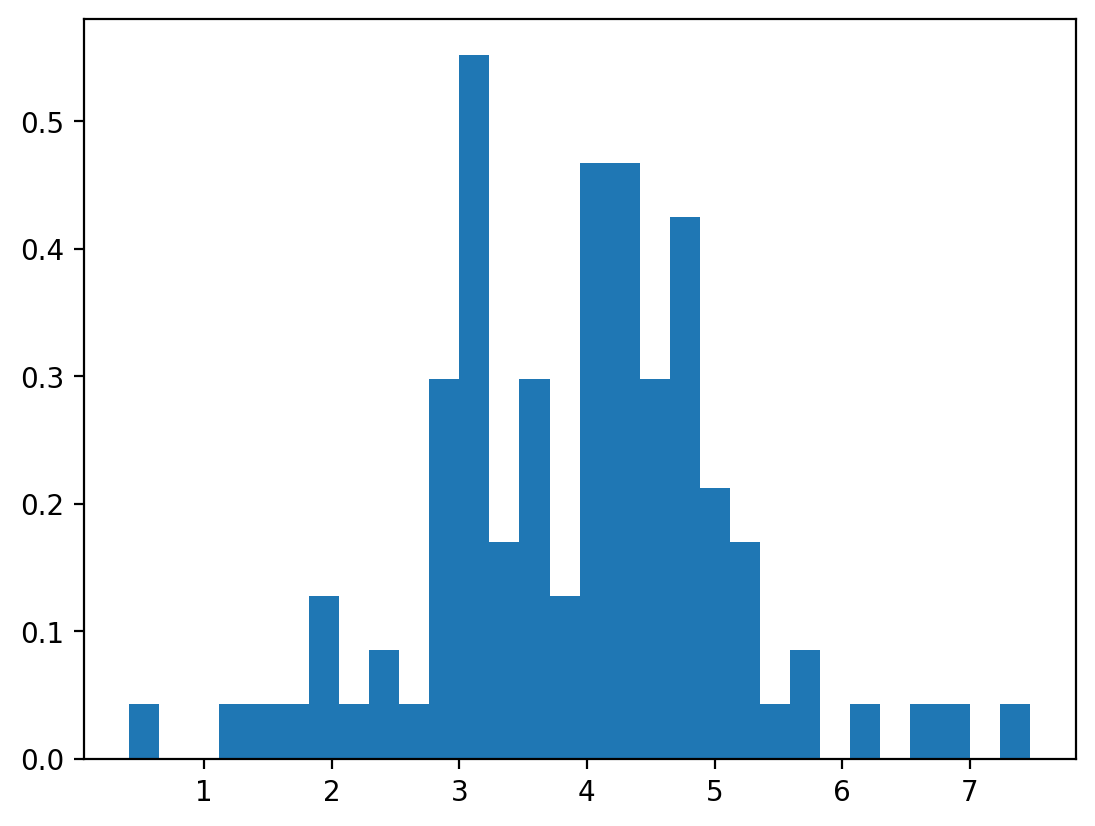

In [6]:
#1
#Sample mean, xbar and std dev, S

N = data.shape[0]

def hetero_mean(x, sigma):
    num = sum(x/sigma**2)
    den = sum(1/sigma**2)
    
    return num/den

def hetero_std(sigma):
    return (sum(1/sigma**2))**(-1/2)



xbar = hetero_mean(x, unc)
sigma_xbar = hetero_std(unc)

print(f'Sample mean = {xbar}, Standard error on mean = {sigma_xbar}')

px, bins, _ = plt.hist(x, 30, density=True);

Optimization terminated successfully.
         Current function value: 147.257863
         Iterations: 18
         Function evaluations: 36
best-fit mean = 3.9179687500000044


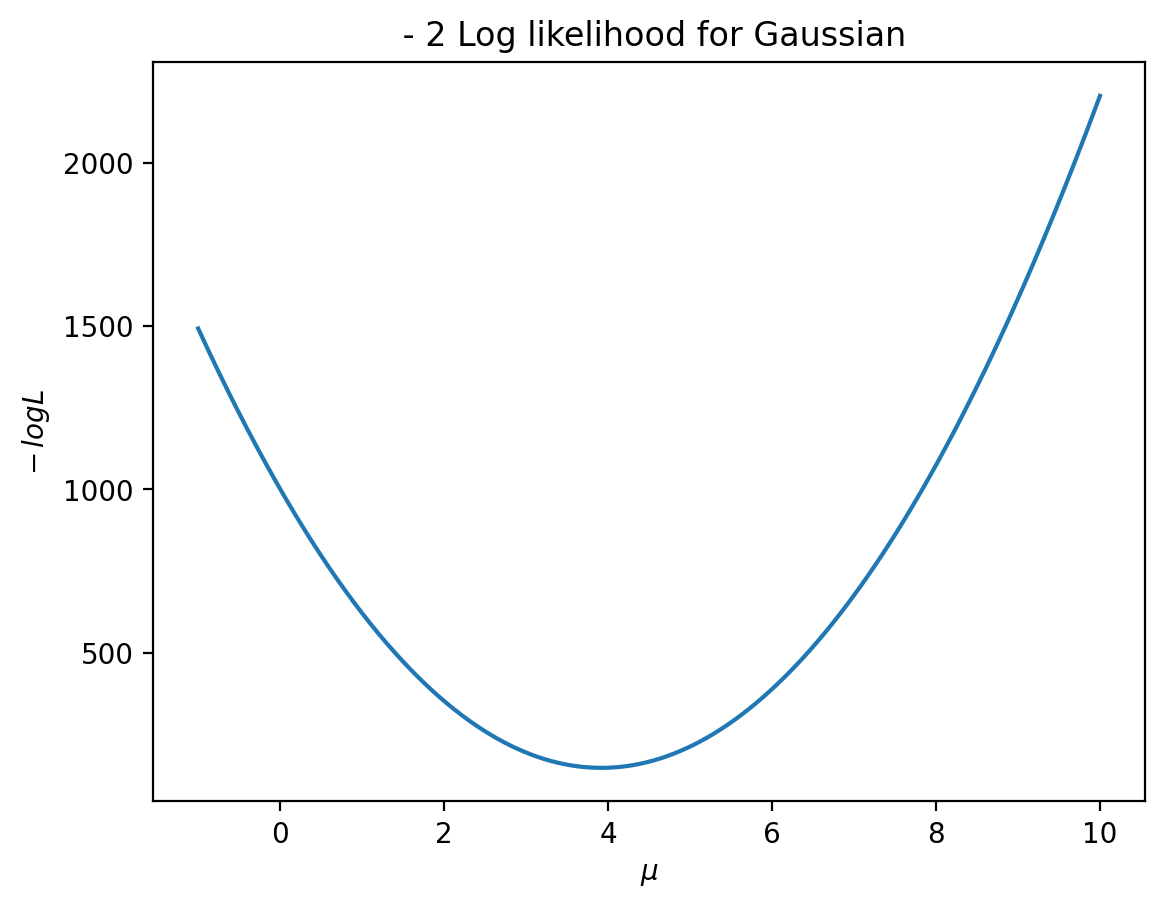

In [7]:
#2

#data = x_i
#Model = N(mu, sigma)

#lnL = -1/2 * sum( ((x_i - mu)/unc_i)**2 )


mu_prop = np.linspace(-1, 10, 10000)


# def chisq_G(mu):
#     #mu is a scalar
#     try:
#         res = np.zeros(len(mu))
#     except:
#         res = 0

#     for i in range(N):
#         res += ( ((x[i] - mu)/unc[i])**2 )
        
#     return res


def lnL_G(mu):
    res = np.zeros(mu.size)
    
    for i in range(N):
        #L = L * norm.pdf(x[i], loc=mu, scale=unc[i])
        res = res - 0.5 * ((x[i] - mu)/unc[i])**2 + np.log(1/np.sqrt(2*np.pi*unc[i]**2))
    
    return res

def neg_lnL_G(mu):
    return - lnL_G(mu)


mu2 = optimize.fmin(neg_lnL_G, 2)[0]
print(f'best-fit mean = {mu2}')

plt.plot(mu_prop, neg_lnL_G(mu_prop))
plt.xlabel('$\mu$')
plt.ylabel('$-\, log L$')
plt.title(' - 2 Log likelihood for Gaussian');

In [8]:
#3
#L = np.ones(mu_prop.size)


def fisher_unc(lnL, theta):
    
    sigma_mu = np.diff(lnL(theta), n=2)
    sigma_mu = sigma_mu/(theta[1]- theta[0])**2
    sigma_mu = -sigma_mu
    sigma_mu = 1/np.sqrt(sigma_mu)[0]

    return sigma_mu

print('Fisher uncertainty =', fisher_unc(lnL_G, mu_prop))


Fisher uncertainty = 0.0948108411671802


Optimization terminated successfully.
         Current function value: 8227.303663
         Iterations: 16
         Function evaluations: 32
[4.04296875]


Text(0.5, 1.0, '- Log likelihood of Laplacian')

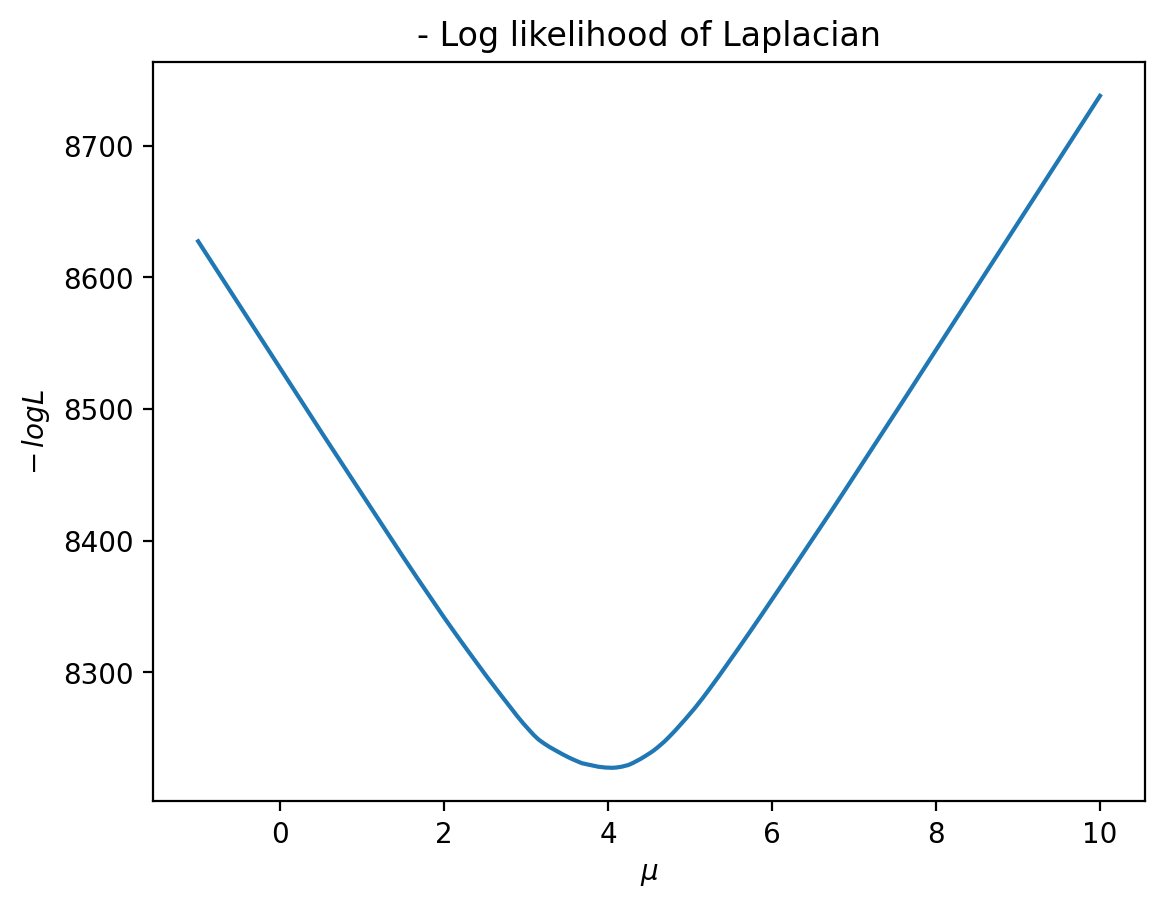

In [9]:
#4 
#Laplace likelihood

def lnL_lap(mu):
    res = np.zeros(len(mu))

    for i in range(N):
        res = res - N * np.log(2*unc[i]) - abs(x[i] - mu)/unc[i]
        
    return res
    
# def chisq_lap(mu):

#     try:
#         res = np.zeros(len(mu))
#     except:
#         res = 0
    
#     for i in range(N):
#         res += ( abs( (x[i] - mu))/unc[i]  )

#     return res

def neg_lnL_lap(mu):
    return - lnL_lap(mu)

#chisq_lap_fn = lambda beta : sum(abs( (x - beta[0])/beta[1] ) )

mu3 = optimize.fmin(neg_lnL_lap, 3)
print(mu3)

plt.plot(mu_prop, neg_lnL_lap(mu_prop))
plt.xlabel('$\mu$');
plt.ylabel('$-\, log L$');
plt.title('- Log likelihood of Laplacian')

I tried optimising the likelihood simultaneously for the both the loc parameter and the scale parameter. But the $\chi^2$ for the scale paramater looked like a delta function at 0, which couldn't be minimised and does not make sense, as shown below. Hence, I optimised only for the loc parameter.

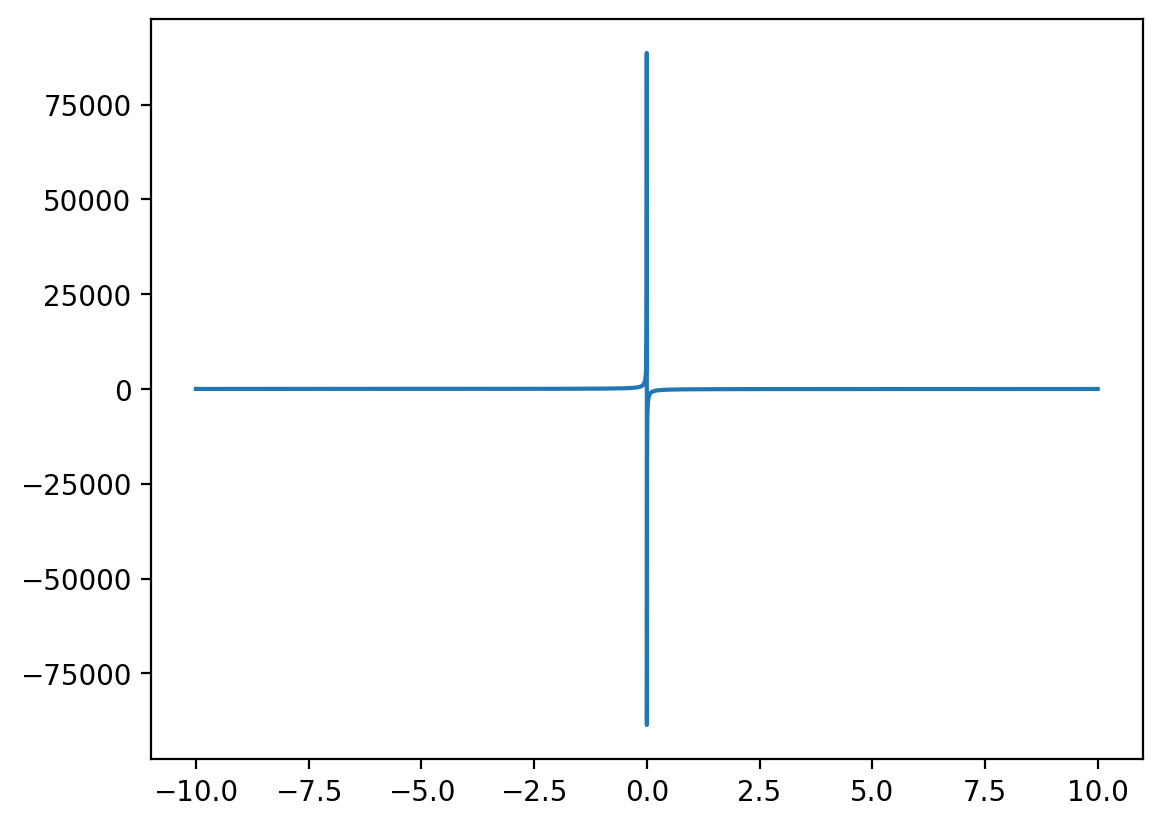

In [10]:
def lnL_lap2(mu, delta):
    try:
        res = np.zeros(len(mu))
    except:
        res = 0
        
    for i in range(N):
        res = res - abs(x[i] - mu)/delta
        
    return res

delta_prop = np.linspace(-10,10, 10000)
plt.plot(delta_prop, lnL_lap2(4, delta_prop))

In [11]:
#5 

#Maxmimum likelihood values
lnL_max_gauss = lnL_G(mu2)
lnL_max_lap = lnL_lap(mu3)

def AIC(lnL_max, k, N):

    return -2 * lnL_max + 2*k + 2*k*(k+1) / (N - k -1) 

AIC_G = AIC(lnL_max_gauss, 1, N)
AIC_L = AIC(lnL_max_lap, 1, N)

print(AIC_G, AIC_L)

[296.55654216] [16456.64814229]


Since the AIC for Gaussian is lower than the Laplacian, Gaussian is the better model. 